# Analyse SHAP values

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_preprocess import pipe_imputation_scaling, pipe_supervisedSelector
import shap
import pickle

from sklearn.pipeline import Pipeline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
translateVarsNames = {
    'Adm_pres_Creat':"creatinine (preop)",
    'Adm_pres_Hb_alt':"haemoglobin (preop)",
    'age_pres':"age",
    'bodypart_adm_pres#Upper_arm':"affected: upper arm",
    'bodypart_adm_pres#Lower_arm':"affected: lower arm",
    'bodypart_adm_pres#Anogenital_region':"affected: anogenital area",
    'Diabetes_M':"diabetes",
    'surg_area_NSTI':"surgery before",
}

In [2]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
datasetTimepoint = "PRESURGERY"
target = "Conclusion_micro"
target_rkz = "GAS_yes_no"
percentBoruta = 100
n_iter = 10000


''' 
Define paths
'''
folderFigures = f"{PATH}/figures/{datasetTimepoint}/50_externalValidation"
resultsPath = f"{PATH}/results/50_externalValidation/{datasetTimepoint}/"
dataPath = f"{PATH}/results/10_preprocessed/validation"

''' 
Read validation data
'''
with open(f"{PATH}/data/validation/validation_dtypes.json", "r") as f:
    dtypes = json.load(f)

data = pd.read_csv(f"{dataPath}/{datasetTimepoint}_{target}_validationData.csv", index_col=None, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())

''' 
Split
'''
X_val = data.drop(target_rkz, axis=1)
y_val = data[target_rkz]#.values

In [3]:
''' Load SHAP'''
with open(f'{resultsPath}/bootstrap_validation_n{n_iter}_shap.pickle', 'rb') as f:
    dic_shap = pickle.load(f)
### sort
dic_shap = dict(sorted(dic_shap.items()))

average_shap_values = []
for k,v in dic_shap.items():
    average_shap_values.append(np.array(v).mean(axis=0)) 

In [7]:
''' 
Prepare dataframe for plotting
'''
num_columns = X_val.select_dtypes(include=["float64"]).columns
bin_columns = X_val.select_dtypes(include=["int64"]).columns
cat_columns = X_val.select_dtypes(include=["object"]).columns
preprocessor = pipe_imputation_scaling(num_columns, bin_columns, cat_columns)  

### Impute test data set on its own to avoid information leakage between internal and external validation!
df_plotting = pd.DataFrame(preprocessor.fit_transform(X_val))
df_plotting.index = X_val.index
columnOrderAfterPreprocessing = [ele[5:] for ele in preprocessor.get_feature_names_out()]
df_plotting.columns = columnOrderAfterPreprocessing

### Inverse transform numerical variables to add to interpretability
num_inverseTransform = preprocessor.transformers_[0][1][0].inverse_transform(df_plotting.loc[:,preprocessor.transformers_[0][2].tolist()])
df_plotting.loc[:,preprocessor.transformers_[0][2].tolist()] = num_inverseTransform


df_plotting.columns = [translateVarsNames[ele] for ele in columnOrderAfterPreprocessing]
df_plotting

,creatinine (preop),haemoglobin (preop),age,affected: upper arm,affected: lower arm,affected: anogenital area,diabetes,surgery before
0,206.0,7.57,82.58,0.0,0.0,0.0,0.0,0.0
1,150.0,14.82,71.37,0.0,0.0,1.0,1.0,0.0
2,151.0,10.15,69.93,0.0,0.0,0.0,0.0,0.0
3,147.0,12.09,55.83,0.0,0.0,1.0,0.0,1.0
4,63.0,9.83,73.20,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
203,178.0,10.15,85.20,0.0,0.0,1.0,1.0,0.0
204,121.0,8.86,80.21,0.0,0.0,0.0,0.0,1.0
205,168.0,8.70,75.84,0.0,0.0,0.0,0.0,0.0
206,79.0,13.86,74.60,0.0,0.0,0.0,0.0,0.0


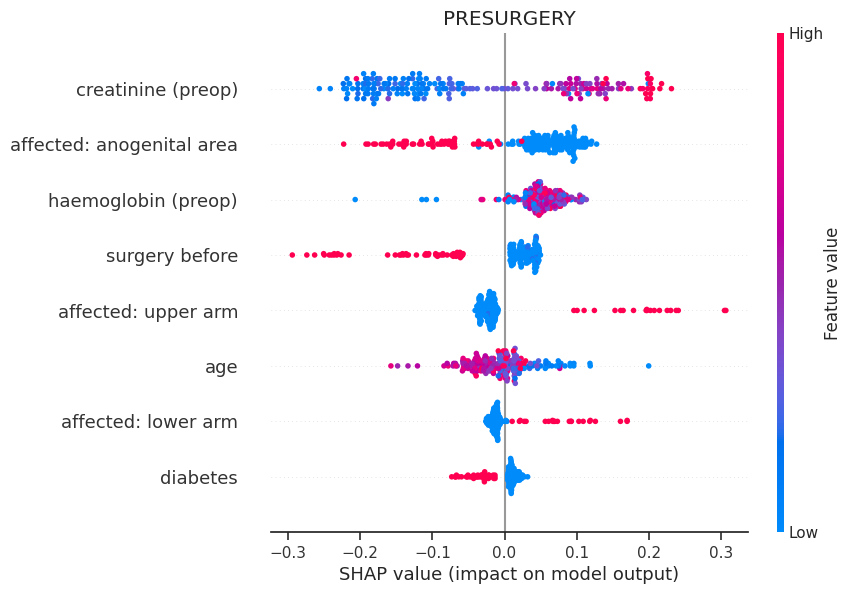

In [8]:
sns.set_theme(style="white", font_scale=1.2)
shap.summary_plot(np.array(average_shap_values), 
                  features=df_plotting,
                  show = False, sort=True, plot_size=(9.0,6.0))
plt.title(f'{datasetTimepoint}')
plt.savefig(f"{folderFigures}/SHAP_n{n_iter}_{datasetTimepoint}.png", dpi=300)

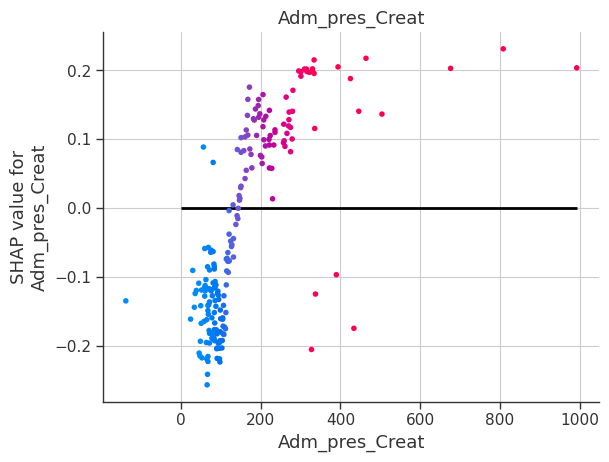

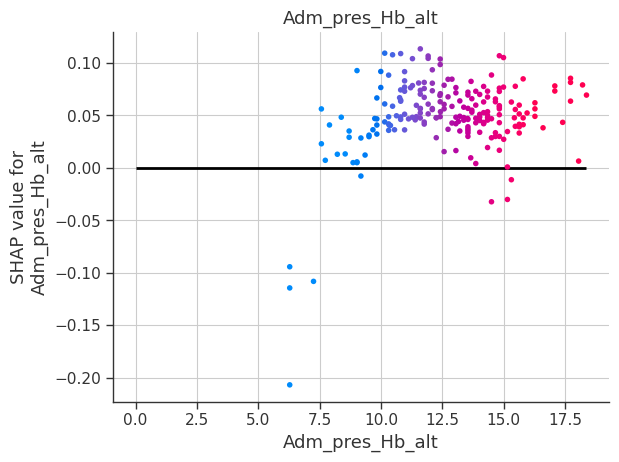

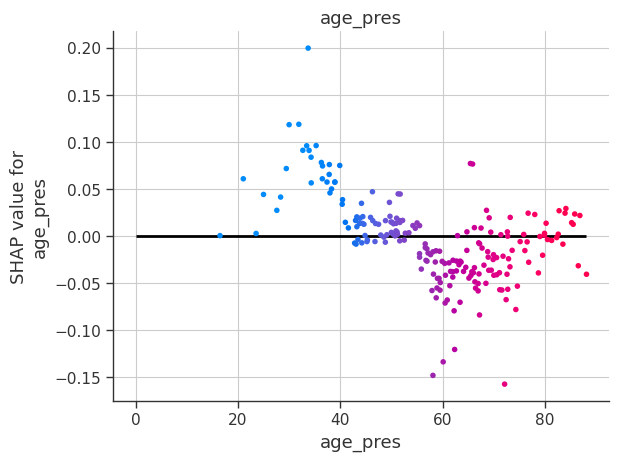

In [22]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")

for i,a in enumerate(df_plotting.loc[:,num_columns]):
    fig, ax = plt.subplots(1,1)
    ax.hlines(y=0, xmin=0, xmax=df_plotting.loc[:,a].max(), linestyles="-", colors='black', alpha=1, linewidth=2,zorder=1)
    shap.dependence_plot(a, np.array(average_shap_values), 
                        df_plotting, 
                        interaction_index=a,
                        ax=ax, title=a)